In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, re
from glob import glob
from tqdm import trange
from copy import deepcopy

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed()

Random seed set as 42


In [3]:
iou_threshold = 0.6  # 0.6
score_threshold = 0.5  # 0.6

max_boxes = 20
image_size = 416
checkpoints = 'checkpoints/yolov3.ckpt' 
num_classes = 1
batch_size = 8

classes_names = {0:"None",1:"face"}  # "None" is technical label for absence of object
classes_names = {0: "face"}

In [4]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / image_size
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

yolo_tiny_anchors = np.array([(10, 14), (23, 27), (37, 58), (81, 82), (135, 169),  (344, 319)], np.float32) / image_size
yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])

In [5]:
def read_annots(file, max_faces=max_boxes):
    def get_coords(line):
        coor = line.split(" ")
        xywh = [int(coor[i]) for i in range(4)] if(len(coor) > 4) else None
        return xywh
    
    data = []
    
    with open(file, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if ".jpg" in line:
                annot = {
                    "path": line.strip(),
                    "box_num": int(lines[i+1]),
                    "boxes": []
                }
                if max_faces >= annot["box_num"]:
                    for j in range(annot["box_num"]):
                        box = get_coords(lines[i+2+j].replace("\n", ""))
                        if box is not None:
                            x,y,w,h = box
                            
                            # cxcywh
                            #center_x, center_y = x+w/2, y+h/2
                            #box = [center_x, center_y, w, h]
                            
                            # xmin, ymin, xmax, ymax
                            box = [x, y, x+w, y+h]
                            annot["boxes"].append(box + [0])  # INITIALLY [1]
                    if len(annot["boxes"]) > 0:
                        data.append(annot)
    return data

In [6]:
train = read_annots("../input/wider-data/WIDER/wider_face_train_bbx_gt.txt")
valid = read_annots("../input/wider-data/WIDER/wider_face_val_bbx_gt.txt")

In [7]:
def preprocess_images(x, size):
    x = tf.image.resize(x, (size, size))
    x = x / 255
    return x

def make_sample(data, max_boxes=max_boxes, path_start="../input/wider-data/WIDER/WIDER_train/"):
    path = path_start + data["path"]
    boxes = data["boxes"]
    padding_factor = max_boxes - len(boxes) if len(boxes) < max_boxes else 0
    x_train = tf.image.decode_jpeg(open(path, 'rb').read(), channels=3)
    height, width = x_train.shape[:2]

    boxes = np.array(boxes).astype(np.float32)
    boxes[..., [0,2]] = np.clip(boxes[..., [0,2]], a_min=0, a_max=width-1)
    boxes[..., [1,3]] = np.clip(boxes[..., [1,3]], a_min=0, a_max=height-1)
    
    boxes[...,[0,2]] /= width
    boxes[...,[1,3]] /= height
    boxes = boxes.tolist()
    
    x_train = preprocess_images(x_train, image_size)
    labels = boxes + [[0, 0, 0, 0, 0]] * padding_factor
    y_train = tf.convert_to_tensor(labels, tf.float32)

    return x_train, y_train

def train_data_generator():
    for sample in train:
        yield make_sample(sample)
        
def valid_data_generator():
    for sample in valid:
        yield make_sample(sample, path_start="../input/wider-data/WIDER/WIDER_val/")

In [8]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x1, y1, x2, y2, obj, class])
    y_true_out = tf.zeros((N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 5+num_classes))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())

def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)  # [x,y,w,h,objectness,class]

In [9]:
def _meshgrid(n_a, n_b):

    return [
        tf.reshape(tf.tile(tf.range(n_a), [n_b]), (n_b, n_a)),
        tf.reshape(tf.repeat(tf.range(n_b), n_a), (n_b, n_a))
    ]

def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = _meshgrid(grid_size[1],grid_size[0])
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32)  # bx = s(tx) + cx, by = s(ty) + cy
    box_wh = tf.exp(box_wh) * anchors  # bw = exp(tw)*pw, bh = exp(tp)*pp

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

def yolo_nms(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    if classes == 1:
        scores = confidence
    else:
        scores = confidence * class_probs
  
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=max_boxes,
        max_total_size=max_boxes,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold)
  
    return boxes, scores, classes, valid_detections

In [10]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0:2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[int(classes[i])],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          1, (0, 0, 255), 2)
    return img


def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

**Check initial targets**

In [11]:
x,y = make_sample(train[10])

2022-11-05 20:34:14.440731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 20:34:14.551453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 20:34:14.552219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 20:34:14.554467: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

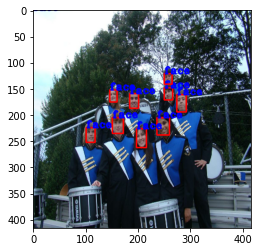

In [12]:
img = draw_labels(x,y,classes_names)
plt.imshow(img)
plt.show()

In [13]:
y_t = transform_targets(tf.expand_dims(y, 0), yolo_tiny_anchors, yolo_tiny_anchor_masks, image_size)

y_out1 = yolo_boxes(y_t[0], yolo_tiny_anchors[yolo_tiny_anchor_masks[0]], 1)
y_out2 = yolo_boxes(y_t[1], yolo_tiny_anchors[yolo_tiny_anchor_masks[1]], 1)

y_out = yolo_nms((y_out1[:3], y_out2[:3]), yolo_tiny_anchors, yolo_tiny_anchor_masks, 1)

boxes, scores, classes, nums = y_out

2022-11-05 20:34:21.420145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


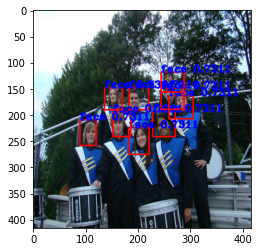

In [14]:
plt.imshow(draw_outputs(x.numpy(), y_out, classes_names))

In [15]:
# Model building blocks

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [16]:
# Native YOLO blocks

def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [17]:
# YOLO final model and Loss

def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=1, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='face_detector')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='face_detector')

def YoloLoss(anchors, classes=1, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                    x[1], tf.cast(x[2], tf.bool))), axis=-1), (pred_box, true_box, obj_mask), tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
        
        # use binary_crossentropy instead of sparse_categorical_crossentropy
        if classes > 1:
            class_loss = obj_mask * sparse_categorical_crossentropy(true_class_idx, pred_class)
        else:
            class_loss = obj_mask * binary_crossentropy(true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [18]:
# Reduced yoloV3 model

def DarknetTiny(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 16, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 32, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 64, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 128, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = x_8 = DarknetConv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 512, 3)
    x = MaxPool2D(2, 1, 'same')(x)
    x = DarknetConv(x, 1024, 3)
    return tf.keras.Model(inputs, (x_8, x), name=name)

def YoloConvTiny(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = DarknetConv(x, filters, 1)

        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloV3Tiny(size=None, channels=3, anchors=yolo_tiny_anchors,
               masks=yolo_tiny_anchor_masks, classes=1, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_8, x = DarknetTiny(name='yolo_darknet')(x)

    x = YoloConvTiny(256, name='yolo_conv_0')(x)
    output_0 = YoloOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = YoloOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)

    if training:
        return Model(inputs, (output_0, output_1), name='face_detector')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3]))
    return Model(inputs, outputs, name='face_detector')

In [ ]:
# define model and training instances
# init lr = 1e-3, no clipvalue: valid loss anomally explodes
# 2 - lr = 1e-4, clipvalue = 1.: 

# model = YoloV3(image_size, training=True, classes=num_classes)
# optimizer = tf.keras.optimizers.Adam(lr=0.0001, clipvalue=1.)  # clipvalue, clipnorm to prevent exploiding gradients
# loss = [YoloLoss(yolo_anchors[mask], classes=num_classes) for mask in yolo_anchor_masks]

# model.compile(optimizer=optimizer, loss=loss,)
# callbacks = [
#             ReduceLROnPlateau(verbose=1),
#             EarlyStopping(patience=3, verbose=1),
#             ModelCheckpoint(checkpoints, verbose=1, save_weights_only=True),
#         ]
# clip: set clipvalue or/and clipnorm
# lr lower
# scheduler patience
# early = 8
# batch_size >
# use tiny model for single class task!
# TODO: make yolo class(Model)

In [23]:
# tiny model (for single class problem)
model = YoloV3Tiny(image_size, training=True, classes=num_classes)
optimizer = tf.keras.optimizers.Adam(lr=0.0001, clipvalue=1.)
loss = [YoloLoss(yolo_tiny_anchors[mask], classes=num_classes) for mask in yolo_tiny_anchor_masks]

model.compile(optimizer=optimizer, loss=loss,)
callbacks = [
            ReduceLROnPlateau(verbose=1, patience=3),
            EarlyStopping(patience=5, verbose=1, restore_best_weights=True),
            ModelCheckpoint(checkpoints, verbose=1, save_weights_only=True),
        ]

In [20]:
model.summary()

Model: "face_detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  6298480     input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 256)  263168      yolo_darknet[0][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 384)  33280       yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][0]   

In [ ]:
# default model
# AUTOTUNE = tf.data.AUTOTUNE
# buffer_size = 256
# 
# train_ds = tf.data.Dataset.from_generator(train_data_generator, 
#                                           output_types=(tf.float32, tf.float32),
#                                           output_shapes=((image_size, image_size, 3), (max_boxes, 5))).shuffle(buffer_size).batch(batch_size).map(lambda x, y: (x, transform_targets(y, yolo_anchors, yolo_anchor_masks, image_size))).prefetch(buffer_size=AUTOTUNE)
# valid_ds = tf.data.Dataset.from_generator(valid_data_generator, 
#                                           output_types=(tf.float32, tf.float32),
#                                           output_shapes=((image_size, image_size, 3), (max_boxes, 5))).batch(batch_size).map(lambda x, y: (x, transform_targets(y, yolo_anchors, yolo_anchor_masks, image_size))).prefetch(buffer_size=AUTOTUNE)

In [24]:
# tiny model
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = 256

output_signature = (tf.TensorSpec(shape=(image_size, image_size, 3), dtype=tf.float32), tf.TensorSpec(shape=(max_boxes, 5), dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(train_data_generator, output_signature=output_signature) \
                                          .shuffle(buffer_size) \
                                          .batch(batch_size) \
                                          .map(lambda x, y: (x, transform_targets(y, yolo_tiny_anchors, yolo_tiny_anchor_masks, image_size))) \
                                          .prefetch(buffer_size=AUTOTUNE)
valid_ds = tf.data.Dataset.from_generator(valid_data_generator, output_signature=output_signature) \
                                          .batch(batch_size) \
                                          .map(lambda x, y: (x, transform_targets(y, yolo_tiny_anchors, yolo_tiny_anchor_masks, image_size))) \
                                          .prefetch(buffer_size=AUTOTUNE)

In [25]:
history = model.fit(train_ds,
                    epochs=100,
                    callbacks=callbacks,
                    validation_data=valid_ds,
                    verbose=1,
                    # steps_per_epoch=len(train) // batch_size + len(train) % batch_size
                   )

Epoch 1/100
1411/1411 [==============================] - 327s 226ms/step - loss: 106.2007 - yolo_output_0_loss: 14.5914 - yolo_output_1_loss: 90.2799 - val_loss: 27.8542 - val_yolo_output_0_loss: 3.1426 - val_yolo_output_1_loss: 23.3808

Epoch 00001: saving model to checkpoints/yolov3.ckpt
Epoch 2/100
1411/1411 [==============================] - 244s 170ms/step - loss: 22.4074 - yolo_output_0_loss: 2.2116 - yolo_output_1_loss: 18.8643 - val_loss: 22.3650 - val_yolo_output_0_loss: 2.0182 - val_yolo_output_1_loss: 19.0168

Epoch 00002: saving model to checkpoints/yolov3.ckpt
Epoch 3/100
1411/1411 [==============================] - 243s 171ms/step - loss: 18.7180 - yolo_output_0_loss: 1.5356 - yolo_output_1_loss: 15.8535 - val_loss: 20.3770 - val_yolo_output_0_loss: 1.6780 - val_yolo_output_1_loss: 17.3735

Epoch 00003: saving model to checkpoints/yolov3.ckpt
Epoch 4/100
1411/1411 [==============================] - 243s 170ms/step - loss: 16.6788 - yolo_output_0_loss: 1.2425 - yolo_output

In [ ]:
# vmodel = YoloV3(size=image_size, classes=1, training=False)
# load_status = 
# vmodel.load_weights(checkpoints).expect_partial()
# load_status.assert_consumed()

In [23]:
# vmodel = YoloV3Tiny(size=image_size, classes=1, training=False)
# load_status = 
# vmodel.load_weights(checkpoints).expect_partial()
# load_status.assert_consumed()

In [24]:
# test_path = "../input/wider-data/WIDER/WIDER_test/1--Handshaking/1_Handshaking_Handshaking_1_144.jpg"
# test_path = "../input/wider-data/WIDER/WIDER_train/19--Couple/19_Couple_Couple_19_1.jpg"
# test_image = tf.image.decode_jpeg(open(test_path, 'rb').read(), channels=3)
# test_image = tf.expand_dims(test_image, 0)
# test_image = preprocess_images(test_image, image_size)
# boxes, scores, classes, nums = vmodel(test_image)

In [ ]:
# for i in range(nums[0]):
#     img = test_image.numpy().squeeze()
#     img = draw_outputs(img, (boxes, scores, classes, nums), classes_names)
# plt.imshow(img)
# plt.show()

#### Appendix

In [ ]:
# convert to cxcywh?, now xmin,ymin,xmax,ymax
# multiply boxes by image_size, now - boxes [0,1]
# apply augmentations? now - not applied
# binary_crossentropy for class_predictions? no
"""
train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)  # use albumentations to convert bboxes either
    .batch(batch_size)
    .prefetch(AUTOTUNE)
+ steps per epoch
"""

In [ ]:
# for debugging purposes
# for epoch in range(1, 101):
#     for batch, (images, labels) in enumerate(train_ds):
#         with tf.GradientTape() as tape:
#             outputs = model(images, training=True)
#             regularization_loss = tf.reduce_sum(model.losses)
#             pred_loss = []
#             for output, label, loss_fn in zip(outputs, labels, loss):
#                 pred_loss.append(loss_fn(label, output))
#             total_loss = tf.reduce_sum(pred_loss) + regularization_loss
# 
#         grads = tape.gradient(total_loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
# 
#         print("{}_train, {}, {}".format(
#             epoch, total_loss.numpy(), list(map(lambda x: np.sum(x.numpy()), pred_loss))))# 

In [29]:
test_paths = glob("../input/wider-data/WIDER/WIDER_test/"+"*/*.jpg")

In [58]:
def check_test(num_cols=5, num_rows=4):
    results, images = [], []
    for _ in range(num_cols * num_rows):
        test_path = test_paths[np.random.randint(len(test_paths))]
        test_image = tf.image.decode_jpeg(open(test_path, 'rb').read(), channels=3)
        test_image = tf.expand_dims(test_image, 0)
        test_image = preprocess_images(test_image, image_size)
        out1, out2 = model(test_image)

        boxes_0 = Lambda(lambda x: yolo_boxes(x, yolo_tiny_anchors[yolo_tiny_anchor_masks[0]], 1),
                         name='yolo_boxes_0')(out1)
        boxes_1 = Lambda(lambda x: yolo_boxes(x, yolo_tiny_anchors[yolo_tiny_anchor_masks[1]], 1),
                         name='yolo_boxes_1')(out2)
        outputs = Lambda(lambda x: yolo_nms(x, yolo_tiny_anchors, yolo_tiny_anchor_masks, 1),
                         name='yolo_nms')((boxes_0[:3], boxes_1[:3]))
        
        images.append(test_image.numpy().squeeze())
        results.append(outputs)
    
    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    pic = 0
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            boxes, scores, classes, nums = results[pic]
            plt.subplot(num_rows, num_cols, index+1)
            img = draw_outputs(images[pic], (boxes, scores, classes, nums), classes_names)
            plt.imshow(img)   
            pic += 1
    plt.show()

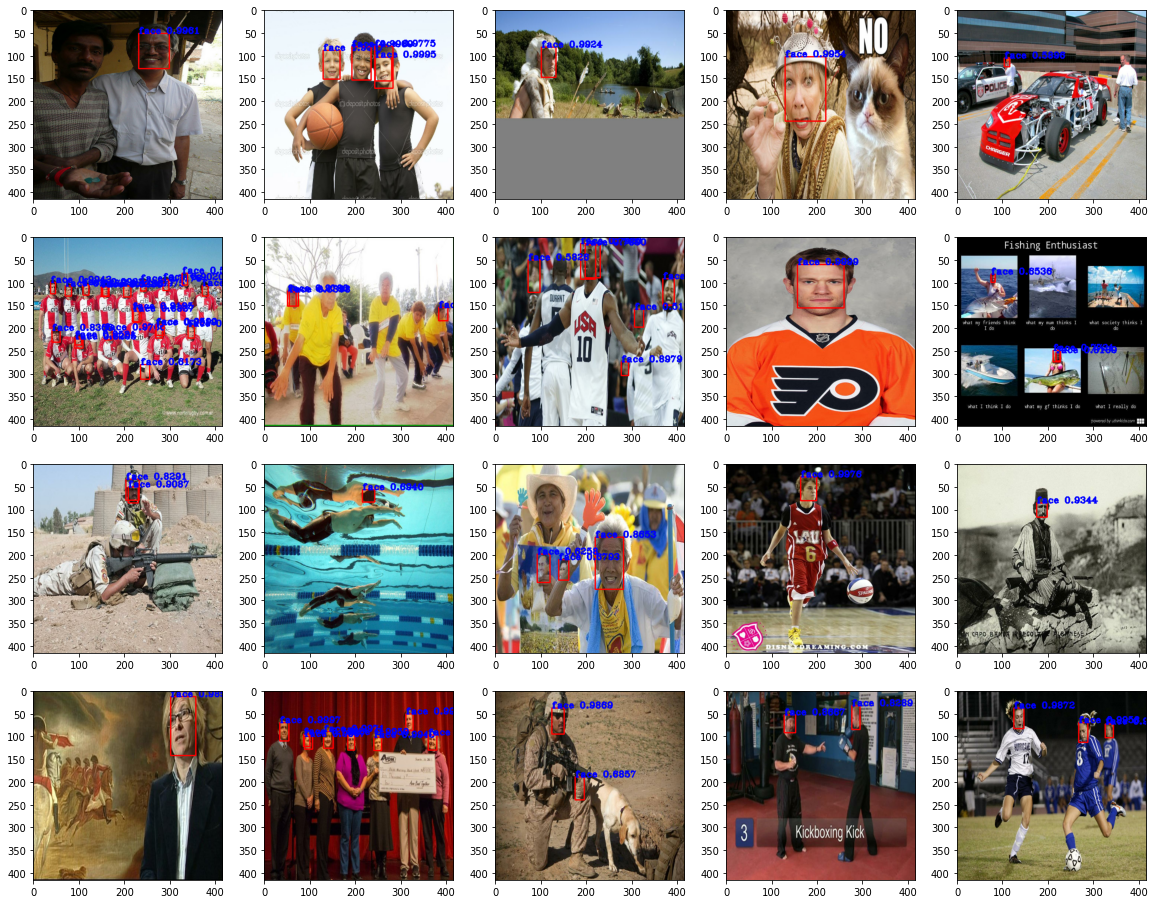

In [55]:
check_test()

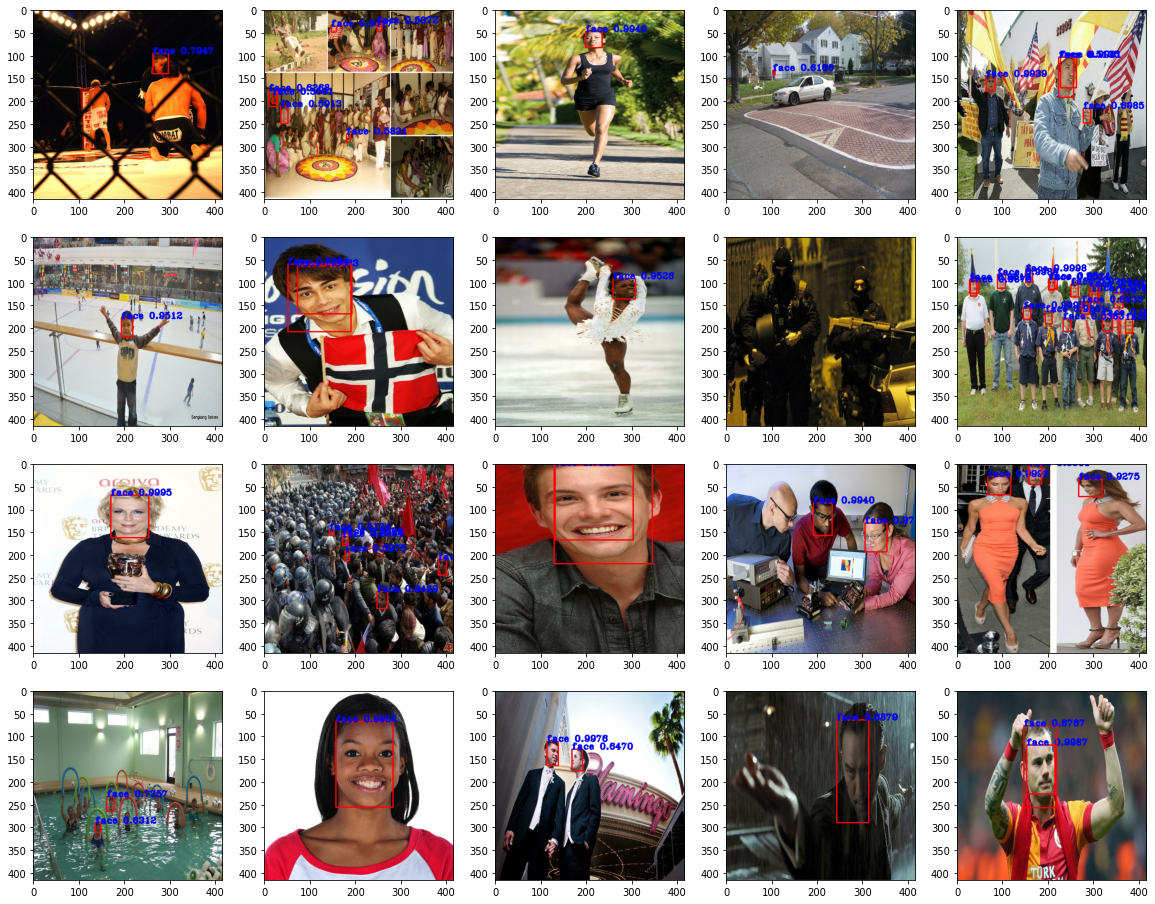

In [56]:
check_test()

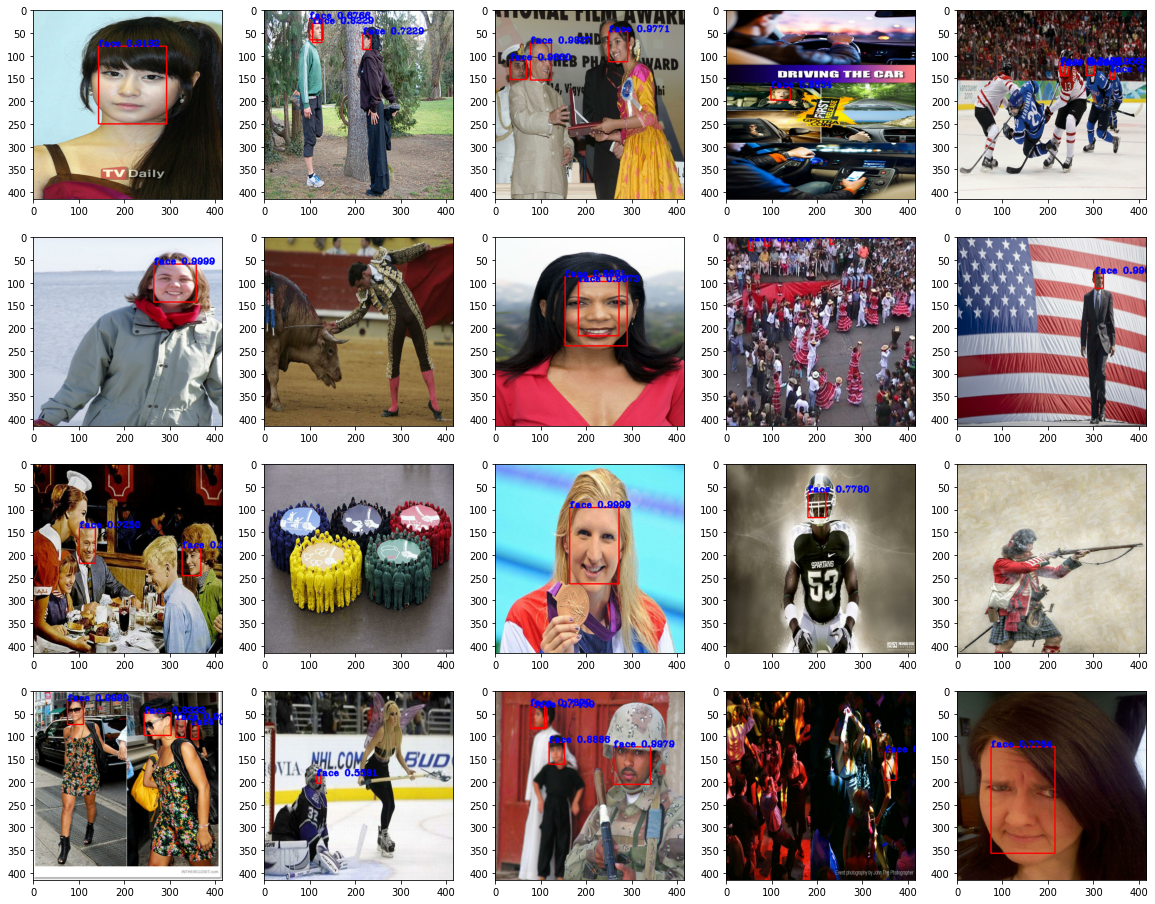

In [60]:
check_test()

### [Results](https://www.kaggle.com/code/pankratozzi/tf-yolo?scriptVersionId=110149144)